# COGS 118A: Supervised Machine Learning Algorithms

## Built-in Logistic Regression and Visualization
## Homework Assignment 6


This HW was an experimental Jupyter notebook format, where written and coded questions were in one notebook. In this assignment, I demonstrate the mathematical steps behind logistic regression, using scikit-learn for it's built in function of logistic regression and manipulating using L1 or L2 norms a long with comparing the results of scaling the data or not, and ultimately, visualized the accuracy and validation curves.

# 1. Logistic Regression

Assume in a binary classification problem, we need to predict a binary label $y\in \{-1,+1\}$ for a feature vector $\mathbf{x}=[x_0,x_1]^\top$. In logistic regression, we can reformulate the binary classification problem in a probabilistic framework: We aim to model the distribution of classes given the input feature vector $\mathbf{x}$. Specifically, we can express the conditional probability $p(y|\mathbf{x})$ parameterized by $(\mathbf w, b)$ using a logistic function. Assume the probability of the positive prediction $p(y=+1|\mathbf{x})$ is represented as:
\begin{align}
p(y=+1|\mathbf{x})=\displaystyle\frac{1}{1+e^{-(\mathbf w^T \mathbf{x} + b)}}
\end{align}


## 1.1 (10 points) Basic Formulation



### 1.1.1 
Please derive the formulation of $p(y=-1|\mathbf{x})$. 

### 1.1.2 
Please show that  $p(y|\mathbf{x})=\displaystyle\frac{1}{1+e^{-y (\mathbf w^T \mathbf{x} + b)}}$. 




## 1.2 (17 points) Derive Gradient

Given a training dataset $S_\text{training} = \{(\mathbf{x}_i, y_i)\}, i=1,\ldots,n\}$, we wish to optimize the negative log-likelihood loss $\mathcal{L}(\mathbf w, b)$ of the logistic regression model defined above:
\begin{equation}
\mathcal{L}(\mathbf w, b)=-\sum_{i=1}^{n} \ln p_i 
\end{equation}

where $p_i = p(y_i|\mathbf{x}_i)$. The optimal weight vector $\mathbf{w}$ and bias $b$ are used to build the logistic regression model:
\begin{equation}
\mathbf{w}^*, b^* = \arg\min_{\mathbf{w}, b}\mathcal{L}(\mathbf{w}, b)
\end{equation}
In this problem, we attempt to obtain the optimal parameters $\mathbf{w}^*$ and $b^*$ by using a standard gradient descent algorithm. 

### 1.2.1 
Please show that $\displaystyle\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial \mathbf{w}} = -\sum_{i=1}^n (1-p_{i}) y_i\mathbf{x}_i$. \\


### 1.2.2

Please show that $\displaystyle\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b} = -\sum_{i=1}^n (1-p_{i}) y_i$.


<img src="one.png">
<img src="two.png">
<img src="three.png">

## Background for Problems 2 - 7

We've already discussed the basic formulation of logistic regression in Problem 1. 

We've seen that it optimizes the log loss  on a training datase using gradient descent. In the example below log loss is augmented by an $L_2$ regularization term, but it could be an $L_1$, an elasticnet mixture of the two, or no regularization at all.
\begin{equation}
\mathcal{L}(\mathbf w, b)= -C \sum_{i=1}^{n} \ln p(y_i|\mathbf{x}_i) + \frac{1}{2} {\lVert \mathbf{w} \rVert_2}^2
\end{equation}


\begin{equation}
\mathbf{w}^*, b^* = \arg\min_{\mathbf{w}, b}\mathcal{L}(\mathbf{w}, b)
\end{equation}

\begin{align}
\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial \mathbf{w}} = -C \sum_{i=1}^n (1-p_{i}) y_i\mathbf{x}_i + \mathbf{w}, \quad\quad
\frac{\partial \mathcal{L}(\mathbf{w},b)}{\partial b} = -C \sum_{i=1}^n (1-p_{i}) y_i.
\end{align}

The log loss function is convex. The regularization term is also convex. The sum of two convex functions is also convex. Therefore gradient descent should be able to find the global optimum.

Once the gradient descent has converged, that is the delta is vanishingly small (under a tolerance threshold), then it has arrived at a flat (within tolerance) spot which must be the global minimum.  An implementation like in scikit-learn will continue gradient descent until it reaches convergence or until reaches a maximum number of iterations. The iterations limit prevents it from spending forever trying to solve an unsolvable problem like when classes are not linearly seperable.  There are many differen numeric solver algorithms that can do this task, each with their own pros and cons. 

We will explore all this below.

## Scikit-learn logistic regression

Let's use sklearn's LogisticRegression class on some not quite seperable binary classes

In [124]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set_style('white')

from sklearn.datasets import load_digits, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler 
from sklearn.preprocessing import RobustScaler, Normalizer, QuantileTransformer, PowerTransformer

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


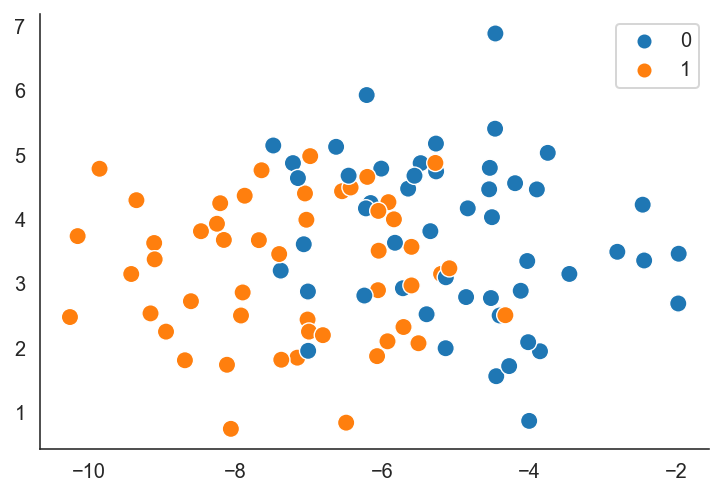

In [125]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=1972, cluster_std=1.2)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75)
sns.despine()
xl = plt.xlim()
yl = plt.ylim()

In [126]:
def plot_decision_probability(model, xlim=(-5,5), ylim=(-5,5)):
    ax = plt.gca()
    cm = plt.cm.RdBu_r
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    Z = model.predict_proba(xy)[:, 1].reshape(X.shape)
    
    # plot decision boundary
    ax.contour(X, Y, P, colors='k', levels=[0])
    
    # plot probabilities
    CS = ax.contourf(X, Y, Z, cmap=cm, alpha=.8)
    fig = plt.gcf();
    cbar = fig.colorbar(CS)
    cbar.ax.set_title('logit probability')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


Here is [scikit-learn's documentation on LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

## 2. Basic use of LogisticRegression()

Enter your code at the prompts below corresponding to the problem numbers here.

### 2.1  (5 points)
Use the docs above to create a classifier with no regularization. 

### 2.2  (5 points)
Get the accuracy of the classifier on the training data

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Training set accuracy 0.79


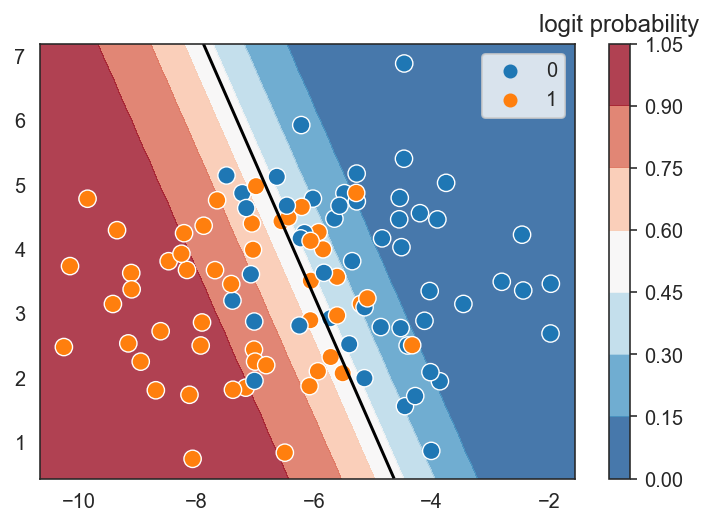

In [127]:
model = LogisticRegression(penalty='none') 

model.fit(X,y)

acc =  model.score(X, y) 

plot_decision_probability(model, xlim=xl, ylim=yl)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);

print(f'Training set accuracy {acc}')

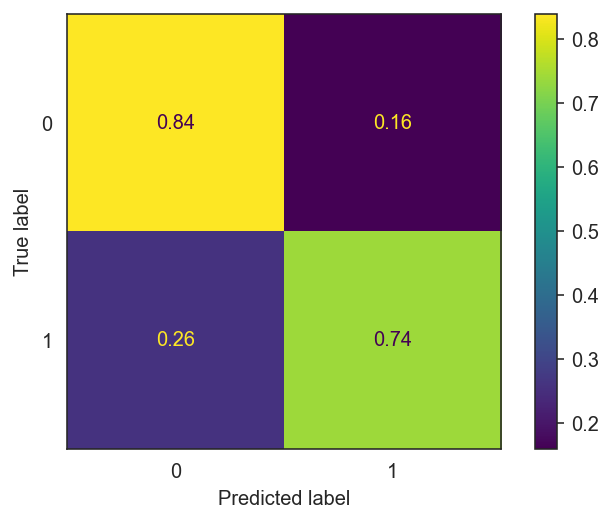

In [128]:
plot_confusion_matrix(model,X,y,normalize='true');

Now do it again below for the regularized version.

## 3. Use L2 regularization with LogisticRegression()
Enter your code at the prompts below corresponding to the problem numbers here. Again you may find [scikit-learn's documentation on LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) helpful



### 3.1 (5 points)

Create a classifier with $L2$ regularization with C=0.001 

### 3.2 (2 points)

Get the accuracy of the classifier on the training data as you did in 2.2

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Training set accuracy 0.77


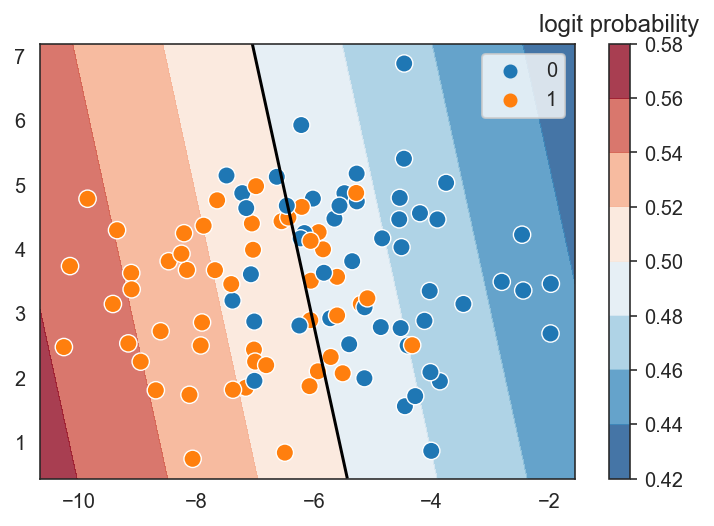

In [129]:
model_l2 =  LogisticRegression(C=0.001) 
model_l2.fit(X,y)
acc = model_l2.score(X,y)  

plot_decision_probability(model_l2, xlim=xl, ylim=yl)
sns.scatterplot(X[:, 0], X[:, 1], hue=y, s=75);

print(f'Training set accuracy {acc}')


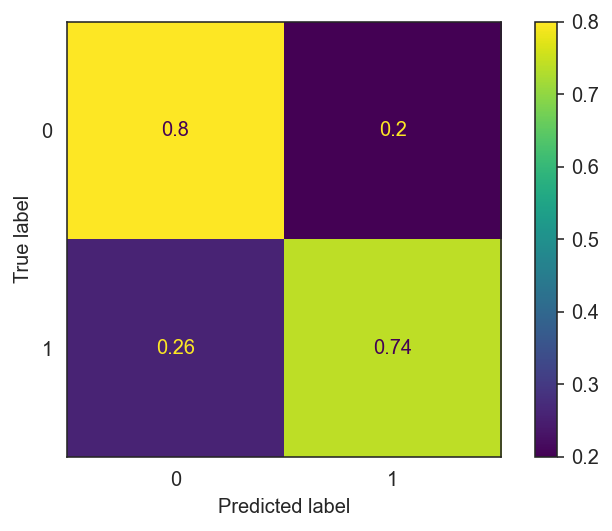

In [130]:
plot_confusion_matrix(model_l2,X,y,normalize='true');

## 4. (10 points) Describe the difference in the no regularization vs the regularized classification


#### Although the accuracy for the no regularization classification was more accurate by 2% on training data (it was 79% versus the regularized classification being 77%), the margin in the regularized classification was wider, meaning that there is more space for new data points in testing data that will have a higher chance being classified correctly.

Now let's try to do some cross-validation to find the best possible value of C to solve a much more complex problem.

The digits dataset is 1797 examples of handwritten digits 0-9, digitized into tiny 8x8 (64) pixel images.  We are going to turn this into a binary classification problem by putting digits 0-4 as the positive class and digits 5-9 as the negative class

In [131]:
digits = load_digits()

X, y = digits.data, digits.target

# classify small against large digits
y = (y > 4).astype(np.int)

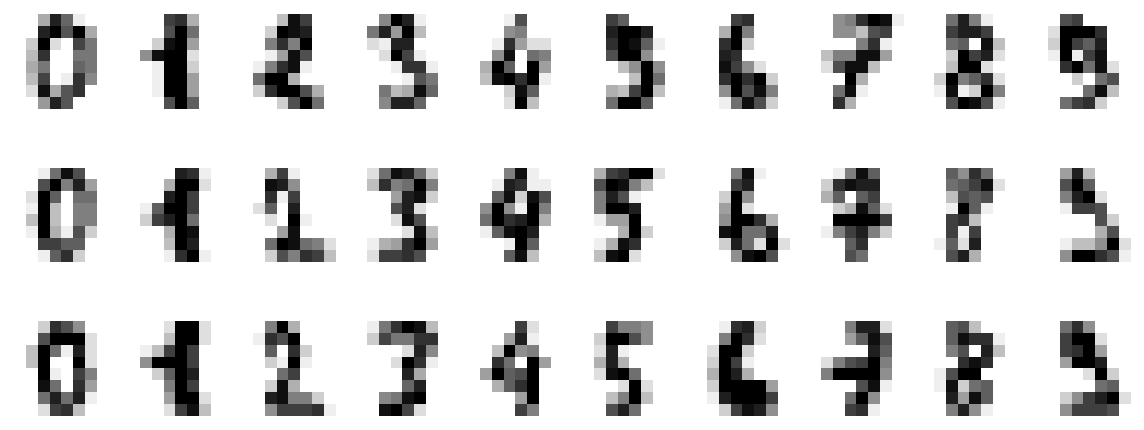

In [132]:
# heres some examples of these super low resolution handwritten digits
fig, axs = plt.subplots(3, 10, figsize=(10,4))
for n, ax in enumerate(axs.flatten()):
    ax.imshow(X[n,:].reshape(8,8), cmap='gray_r')
    ax.axis('off')
    


To encode each image we just turn the 8x8 image into a single 64 long vector. That is we pretend that each pixel is just an independent variable from which we are trying to  

Below we are going to try out several difference values of C (inside the list `Cvals`).  For each C, we will do 5 fold cross-validation, and see what the mean validation accuracy is across all 5 folds.  The C value with the highest accuracy is our best choice. 

## 5. Validation curve

Enter your code at the prompts below corresponding to the problem numbers here.



### 5.1 (5 points)
Instantiate the correct logistic regression setup for each C value we test. Note that you may have to adjust the solver's parameters if you encounter a `Convergence Warning`. This means that the numercial solver perfroming gradient descent did not reach a flat enough (delta < tolerance) area before reaching the maximum allowable number of gradient descent steps.  The answer you have is an answer, but it is not a good enough answer because gradient descent didn't finish! You will need to look at the sklearn docs to figure out how to fix this issue.

### 5.2 (5 points)
Use the kfold cross validation to create two lists: `train` and `holdhout` which have the indices of those elements of the `X` matrix that will be used for the training and holdout (validation) at each iteration (fold of the cross validator)

### 5.3 (5 points)
Make a plot showing C value on x-axis and cross-validation score on the y-axis. You will need to make the x-axis a log scale so we can see things properly. Some relevant docs are: [pandas.DataFrame.plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) and the [pandas plotting tutorial](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)

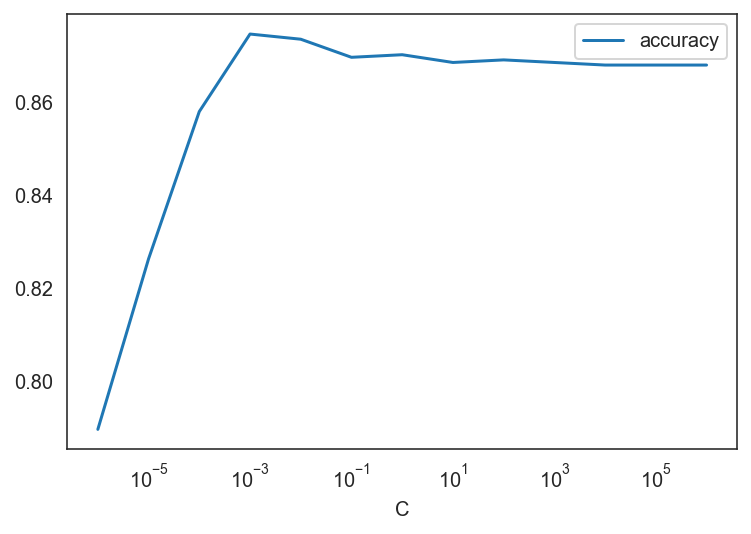

,C,accuracy
0,0.000001,0.789649
1,0.000010,0.826377
2,0.000100,0.858097
3,0.001000,0.874791
4,0.010000,0.873678
5,0.100000,0.869783
6,1.000000,0.870339
7,10.000000,0.868670
8,100.000000,0.869226
9,1000.000000,0.868670


In [133]:
Cvals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
k_fold = KFold(n_splits=5)

results_l2=[]
for C in Cvals:
    # instantiate a logistic regression with L2 penalty and the proper C value for this iteration of the loop
    model = LogisticRegression(C=C, solver='newton-cg') 
    
    # collect the predicted y values and true y values of each hold out set
    predicteds=[]
    trueys=[]
    for train, holdout in k_fold.split(X):
        #scaler = StandardScaler()
        #X[train] = scaler.fit(X[train])
        model.fit(X[train],y[train])
        predicteds.append( model.predict(X[holdout]) )
        trueys.append( y[holdout] )

    # this is because we ended up with a list of arrays, one entry per fold
    # we need a flat array of all the folds together
    predicteds = np.concatenate(predicteds)
    trueys = np.concatenate(trueys)
    
    results_l2.append( [C, accuracy_score(trueys,predicteds)] ) 

results_l2 = pd.DataFrame( results_l2, columns=['C', 'accuracy'])

ax= plt.gca()
results_l2.plot(kind='line',x='C',y='accuracy',ax=ax, logx=True)
plt.show()

results_l2

## Oops
We have committed one of the fundamental errors of Machine Learning.  We applied a technique without really knowing if it was appropriate to our data. Generally in any ML or data analysis problem the first thing to do is to check out the data in as raw a form as you can. Then do some summary statistics to check out its properties.  Let's fix this problem below

Let's see what the raw pixel values are like... Hmmm looks like there are 16 levels of gray, and most measurements are 0. The rest of the gray values are pretty uniformly distributed, except for slightly more 15s. 

count    115008.000000
mean          4.884165
std           6.016814
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max          16.000000
dtype: float64

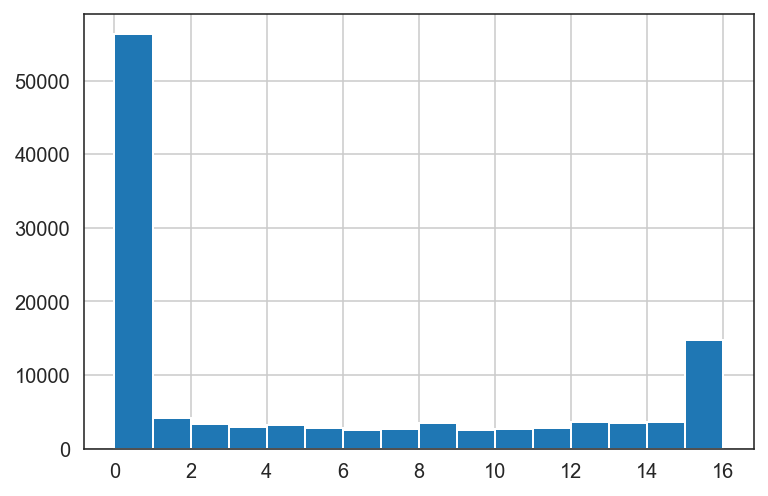

In [134]:
xvals = pd.Series( X.ravel()) # this are just all the pixel values in one lump 
xvals.hist(bins=16)
xvals.describe()

Looks like the mean values per pixel are mostly zeros, and a bit bimodal looking. Whatever the exact distribution, the important part is that there are definitely pixels with very different average brightnesses.  The difference range over a factor of 10x.  Which is maybe just big enough to be worried about in terms of the algorithm preferring class-predicting large magnitude pixels to similarly good at class-predicting small magnitude pixels.

count    64.000000
mean      4.884165
std       4.207763
min       0.000000
25%       0.297718
50%       4.464942
75%       8.747635
max      12.089037
dtype: float64

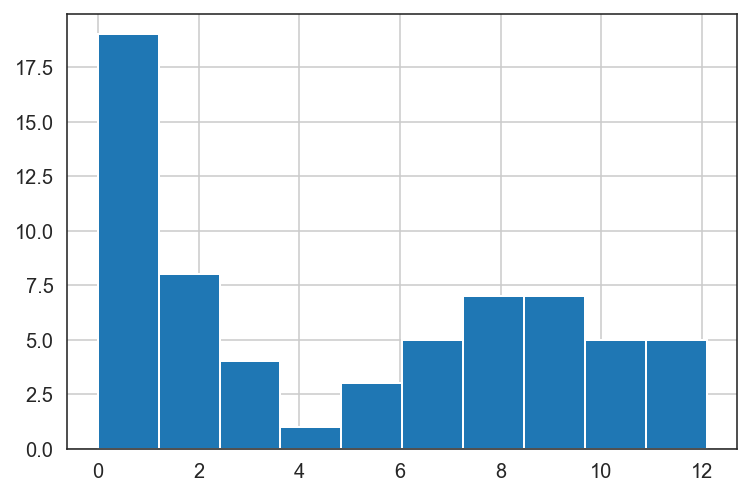

In [135]:
# hmm, lets see if the mean values for each pixel (vector element) are roughly the same
# maybe there are some pixels which tend to be darker on average than others?
xvals_per_pixel = pd.DataFrame(X)
xvals_per_pixel.mean().hist()
xvals_per_pixel.mean().describe()
# yep

We see very much the same pattern with standard deviation, but even moreso. There are pixels with brightness that is highly variable and pixels which are always about the same.  This also about an order of magnitude, and therefore maybe just big enough for us to worry about.

count    64.000000
mean      3.684032
std       2.300911
min       0.000000
25%       1.024137
50%       4.268115
75%       5.819658
max       6.537955
dtype: float64

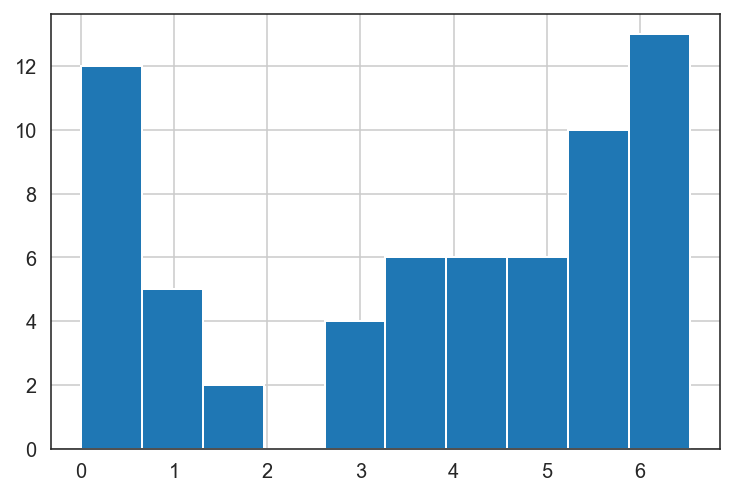

In [136]:
# hmm, lets see if the standard deviation of the values for each pixel (vector element) are roughly the same
# maybe there are some pixels which tend to be much more varied in their brightness on than others?
xvals_per_pixel.std().hist()
xvals_per_pixel.std().describe()
# yep

Now these differences are only a factor of 10 between different variables. But we do know that Logistic Regression is an algorithm that can tend to rely more on variables that have larger magnitude than smaller magnitude variables.  The results above indicate that we there probably isn't much to worry about, but we should at least see if rescaling the variables will change our results.

## 6. Use standard scaler with L2 regularization to generate a validation curve

Enter your code at the prompts below corresponding to the problem numbers here.
 

### 6.1 (5 points)
Transform the X variable using [sklearn.preprocessing.StandardScaler()](https://scikit-learn.org/stable/modules/preprocessing.html)

### 6.2 (2 points)
Reuse the LogisticRegression call from 5.1

### 6.3 (2 points)
Reuse the k-folds for loop from 5.2, but change X to Xsc!

### 6.4 (2 points)
Reuse the plot command from 5.3


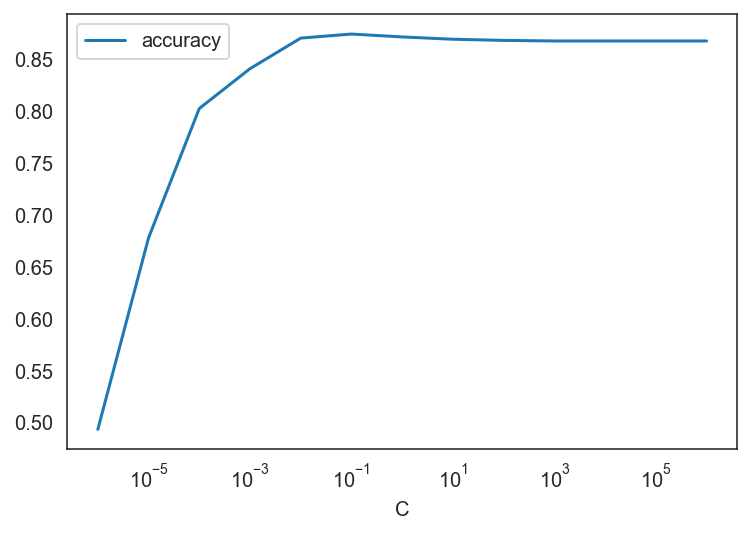

,C,accuracy
0,0.000001,0.493600
1,0.000010,0.678353
2,0.000100,0.803005
3,0.001000,0.841402
4,0.010000,0.870896
5,0.100000,0.874791
6,1.000000,0.872009
7,10.000000,0.869783
8,100.000000,0.868670
9,1000.000000,0.868114


In [137]:
Xsc =  (StandardScaler().fit(X)).transform(X)


Cvals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
k_fold = KFold(n_splits=5)

results_l2sc=[]
for C in Cvals:
    # instantiate a logistic regression with L2 penalty and the proper C value for this iteration of the loop
    model =  LogisticRegression(C=C, solver='newton-cg')
    
    # collect the predicted y values and true y values of each hold out set
    predicteds=[]
    trueys=[]
    for train, holdout in k_fold.split(Xsc): ##### Note you better change X to Xsc!!!
        model.fit(Xsc[train],y[train])
        predicteds.append( model.predict(Xsc[holdout]) )
        trueys.append( y[holdout] )

    # this is because we ended up with a list of arrays, one entry per fold
    # we need a flat array of all the folds together
    predicteds = np.concatenate(predicteds)
    trueys = np.concatenate(trueys)
    
    results_l2sc.append( [C, accuracy_score(trueys,predicteds)] ) 

results_l2sc = pd.DataFrame( results_l2sc, columns=['C', 'accuracy'])
#### (6.4) YOUR CODE GOES HERE ##### 
ax= plt.gca()
results_l2sc.plot(kind='line',x='C',y='accuracy',ax=ax, logx=True)
plt.show()

results_l2sc

## 7. L1 normalization with standardized inputs

Let's try an L1 normalized LogisticRegression(), and for simplicity we will only consider the case where we use StandardScaler().

### 7.1 (5 points)
Instantiate the correct model with L1 penalty. Note that you will have to change the solver as the default does not allow L1. Again you may find [scikit-learn's documentation on LogisticRegression()](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) helpful. To help us make the results reproducible please add the argument `random_state=42` to your call as well  


### 7.2 (2 points)
Reuse the k-folds for loop from 5.2, but change X to Xsc!

### 7.3 (2 points)
Reuse the plot command from 5.3

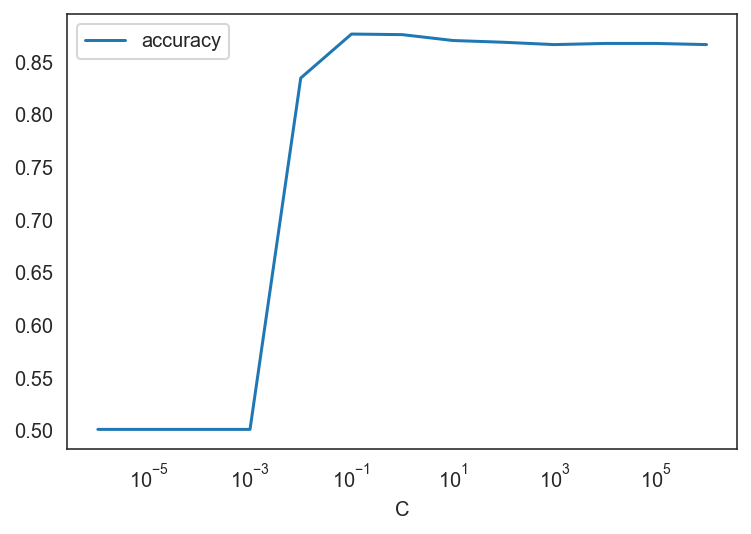

,C,accuracy
0,0.000001,0.501391
1,0.000010,0.501391
2,0.000100,0.501391
3,0.001000,0.501391
4,0.010000,0.834725
5,0.100000,0.876461
6,1.000000,0.875904
7,10.000000,0.870339
8,100.000000,0.868670
9,1000.000000,0.866444


In [138]:

Cvals = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
k_fold = KFold(n_splits=5)

results_l1sc=[]
for C in Cvals:
    # instantiate a logistic regression with L1 penalty and the proper C value for this iteration of the loop
    model = LogisticRegression(penalty='l1', C=C, solver='liblinear') 
    
    # collect the predicted y values and true y values of each hold out set
    predicteds=[]
    trueys=[]
    for train, holdout in k_fold.split(Xsc):#### (7.2) YOUR CODE GOES HERE ##### 
        model.fit(Xsc[train],y[train])
        predicteds.append( model.predict(Xsc[holdout]) )
        trueys.append( y[holdout] )

    # this is because we ended up with a list of arrays, one entry per fold
    # we need a flat array of all the folds together
    predicteds = np.concatenate(predicteds)
    trueys = np.concatenate(trueys)
    
    results_l1sc.append( [C, accuracy_score(trueys,predicteds)] ) 

results_l1sc = pd.DataFrame( results_l1sc, columns=['C', 'accuracy'])
#### (7.3) YOUR CODE GOES HERE ##### 
ax= plt.gca()
results_l1sc.plot(kind='line',x='C',y='accuracy',ax=ax, logx=True)
plt.show()

results_l1sc

OK lets put all 3 models validation curves together and take a look at how the different model/feature setups we've tried have changed what happened 

,C,max accuracy
model,,
"L1,scaled",0.100,0.876461
"L2,raw",0.001,0.874791
"L2,scaled",0.100,0.874791


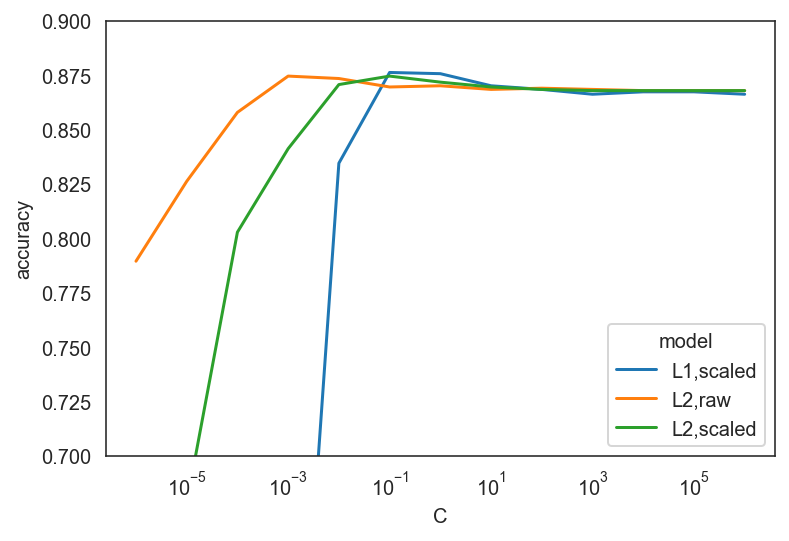

In [139]:
results_l1sc['model']='L1,scaled'
results_l2['model']='L2,raw'
results_l2sc['model']='L2,scaled'
results_all=pd.concat([results_l1sc,results_l2,results_l2sc])

sns.lineplot(data=results_all, x='C', y='accuracy', hue='model')
plt.ylim(0.7,0.9)
plt.xscale('log')

results_all.groupby('model').apply( lambda x: 
                                   x.sort_values(by='accuracy',ascending=False)
                                   .iloc[0]
                                   .drop('model')
                                   .rename({'accuracy':'max accuracy'})
                                  ) 

## 8. (10 points) Compare the different model forms you've tried
Write a short paragraph about the difference in validation curves between unscaled L2, scaled L2, and scaled L1 

## Type your comparison here


    All validation curves plateu to about 86% accuracy as the number of c's are continuously increasing, and it's also important to note that the max accuracies for every validation curve is either the same (in the case of L2 raw and scaled), or less than a full percent more accurate (L1 scaled is about 0.2% more accurate at it's max accuracy). With that being said, the main differences between the validation curves between the unscaled and scaled L2, and the scaled L1, is the C value that their max accuracy occured. I would say the differences in the accuracy are so minimal to choose the best classification, you'd have to rely on the positives and negatives of the C values the highest accuracy occured. L2 raw (or unscaled) was able to reach it's maximum accuracy at the smallest value of C. Smaller values of C indicates a softer margin, there is higher regularization (and low invariance), but bias toward simple solutions. While the scaled L1 and l2 have the same value for C where their max accuracy occurs, and higher C values correlate with a harder margin, lower regularization, but very little to almost no bias. In order to choose the best calculation you'd have to determine how much you care about misscalsifications.